Ομάδα 4

Νίκος Χάιδος, AM: 03118096

Αργύρης Μανέτας, AM:            03117019

Ελευθέριος Λυμπερόπουλος, AM:   03117061

#Kaggle Dataset

### Επισκόπηση του Dataset

Το dataset αναφέρεται σε αστρικά αντικείμενα, και συγκεκριμένα, τα ταξινομεί σε 'Galaxy', 'Star' ή 'Quasar'.
Αρχικά από την περιγραφή του, βλέπουμε ότι αρκετά χαρακτηριστικά αποσκοπούν σε οργανωτικά θέματα, όπως Identifiers και γενικά χαρακτηριστικά από την αρχική εικόνα. Εν τέλει καταλήγουμε σε 10 (double) χαρακτηριστικά και ένα label.

Εφόσον δεν μάς ενδιαφέρουν συγκεκριμένα τα False positive/negative, αλλά θέλουμε να ξέρουμε συνολικά το πλήθος των αντικειμένων που πετύχαμε, θα χρησιμοποιήσουμε ως μετρική το accuracy.

#### Ως προς το splitting σε train και test dataset, μπορούμε να βάλουμε 70-30, γιατί ήδη έχουμε αρκετά δείγματα (100 χιλιάδες) και μπορούμε να μειώσουμε τον υπολογιστικό φόρτο για το fitting.

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=Warning)

In [ ]:
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

df = pd.read_csv("../input/sloan-digital-sky-survey-dr16/Skyserver_12_30_2019 4_49_58 PM.csv")
df = df.drop(['run', 'rerun', 'camcol', 'field', 'objid', 'specobjid', 'fiberid'], axis = 1)
x = df.drop(['class'], axis=1)
y = df['class']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30)
print(f"Συνολικά, έχουμε {(y_train.value_counts())['GALAXY']} δείγματα από την κλάση GALAXY, {(y_train.value_counts())['STAR']} δείγματα από την κλάση STAR και {(y_train.value_counts())['QSO']} δείγματα από την κλάση QUASAR στο training set." )

Συνολικά, έχουμε 36005 δείγματα από την κλάση GALAXY, 26591 δείγματα από την κλάση STAR και 7404 δείγματα από την κλάση QUASAR στο training set.


In [ ]:
print("Επίσης, βλέπουμε ότι δεν χρειάζεται να κάνουμε κάποιο imputing, αφού δεν υπάρχει κανένα χαρακτηριστικό που να έχει missing values στα δεδομένα μας.")
print(x_train.isnull().sum().to_string())

Επίσης, βλέπουμε ότι δεν χρειάζεται να κάνουμε κάποιο imputing, αφού δεν υπάρχει κανένα χαρακτηριστικό που να έχει missing values στα δεδομένα μας.
ra          0
dec         0
u           0
g           0
r           0
i           0
z           0
redshift    0
plate       0
mjd         0


In [ ]:
print("Όσο για τα Variances που θα επιλέξουμε για τον VarianceThreshold, κοιτάμε ανά χαρακτηριστικό περίπου τι τιμές έχουμε, για να επιλέξουμε κατάλληλο parameter grid αργότερα")
print(*(x_train.var(axis=0)), sep="\n")

Όσο για τα Variances που θα επιλέξουμε για τον VarianceThreshold, κοιτάμε ανά χαρακτηριστικό περίπου τι τιμές έχουμε, για να επιλέξουμε κατάλληλο parameter grid αργότερα
6078.460421134806
423.50251061125516
0.6943034664538194
0.9732883273265153
1.2897261257312236
1.4661682617807696
1.6490547717757358
0.19133342885482438
4884870.209922411
2390858.3334018434


##### Οι πολύ μεγάλες τιμές στις διακυμάνσεις τεσσάρων χαρακτηριστικών, σημαίνει ότι μπορεί να έχουμε outliers στα δείγματα, γι'αυτό θα χρησιμοποιήσουμε τον RobustScaler.

Θα εξετάσουμε την απόδοση δύο ταξινομητών, ενός Mylti-Layer Perceptron (MLP) και ενός Support Vector Machines (SVM). <br>

* O ταξινομητής MLP είναι ένα πλήρως διασυνδενδεμένο δίκτυο με ένα ή περισσότερα στρώματα από nodes μεταξύ της εισόδου και της εξόδου. Κάθε νευρώνας των στρωμάτων έχει Ν weighted εισόδους και μια συνάρτηση ενεργοποίησης.
* Ο ταξινομητής SVM έχει στόχο την εύρεση του υπερεπιπέδου που διαχωρίζει όσο καλύτερα μπορεί τις δύο κλάσεις. Στην περίπτωση του linear SVM, αν w είναι ο πίνακας βαρών και το υπερεπίπεδο έχει εξίσωση y = x * w.T + b, τότε αυτός ο στόχος επιτυγχάνεται με το εξής σκεπτικό: <br>
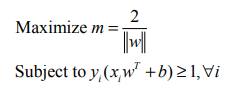 

<h2>Out-of-box metrics</h2>
Παρακάτω βλέπουμε τα out-of-box accuracies του MLP.

In [ ]:
import sklearn
import time
from sklearn.neural_network import MLPClassifier as MLP
from sklearn.model_selection import cross_val_score

x_train = x_train.to_numpy()
y_train = y_train.to_numpy()
x_test = x_test.to_numpy()
y_test = y_test.to_numpy()

estimator = MLP()
estimator.fit(x_train, y_train)
pred_ootb_MLP = estimator.predict(x_test)
print(f'Οι επιδοσεις για τον Out-of-the-Box MLP είναι:\n')
print(sklearn.metrics.classification_report(y_test, pred_ootb_MLP))

Οι επιδοσεις για τον Out-of-the-Box MLP είναι:

              precision    recall  f1-score   support

      GALAXY       0.56      1.00      0.72     15318
         QSO       0.75      0.67      0.71      3177
        STAR       1.00      0.00      0.00     11505

    accuracy                           0.58     30000
   macro avg       0.77      0.56      0.48     30000
weighted avg       0.75      0.58      0.44     30000



Παρακάτω βλέπουμε τα out-of-the-box accuracies του SVM για διάφορους kernels. Επειδή όμως τα δείγματα του train dataset είναι της τάξης μεγέθους του $10^4$, δεν είναι πρακτικό να χρησιμοποιηθεί η υλοποίηση του απλού SVC της scikit-learn χωρίς preprocessing, διότι αυτή η υλοποίηση αυξάνει το χρόνο του fit τετραγωνικά με τα δείγματα. Για αυτό, θα κάνουμε πρώτα **stratified sampling** στο dataset έτσι ώστε να μειώσουμε τα δείγματα, διατηρώντας τα ποσοστά εμφάνισης των κλάσεων. Για το stratified sampling θα χρησιμοποιήσουμε τη συνάρτηση StratifiedShuffleSplit. Έπειτα από δοκιμές διαπιστώσαμε ότι για να έχουμε έναν ικανοποιητικό χρόνο εκτέλεσης του fit, θα χρησιμοποιήσουμε 500 δείγματα στο train set.

In [ ]:
%%time
from sklearn.svm import LinearSVC, SVC
from sklearn.metrics import accuracy_score, f1_score
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
from tqdm import tqdm

from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))
    return
    
x = np.array(x)
y = np.array(y)
sss = StratifiedShuffleSplit(n_splits=1, train_size=0.005, random_state=0)
train_index, test_index = next(sss.split(np.zeros(x.shape[0]), y))

x_train, x_test = x[train_index], x[test_index]

y_train, y_test = y[train_index], y[test_index]

acc_d = dict()
kernels = ['linear', 'poly', 'rbf', 'sigmoid']
for kernel in tqdm(kernels):
    svm = SVC(kernel=kernel)
    svm.fit(x_train, y_train)
    preds = svm.predict(x_test)
    acc = accuracy_score(preds, y_test)
    acc_d[kernel] = acc
    
print("Accuracy:")
for i, k in acc_d.items():
    print("Kernel:", i, " =", str(k))

100%|██████████| 4/4 [00:10<00:00,  2.67s/it]

Accuracy:
Kernel: linear  = 0.6675778894472362
Kernel: poly  = 0.5817688442211055
Kernel: rbf  = 0.5687839195979899
Kernel: sigmoid  = 0.5132261306532663
CPU times: user 10.9 s, sys: 5.96 ms, total: 10.9 s
Wall time: 10.9 s


Βλέπουμε ότι ο πυρήνας που δίνει το μεγαλύτερο accuracy είναι ο linear, αφού δοκιμάσαμε πολλές φορές με διαφορετικά υποσύνολα του dataset. Επειδή όμως αλλάζει και το accuracy ανάλογα με το υποσύνολο του dataset, οπότε δεν θα έχουμε αξιόπιστα αποτελέσματα, θα δοκιμάσουμε μια άλλη υλοποίηση του scikit learn, την LinearSVC, η οποία είναι ένα SVM με γραμμικό kernel. Αυτή η υλοποίηση εκτελεί το fit σε γραμμικό χρόνο ανάλογα με τα δείγματα και κλιμακώνει καλύτερα με μεγάλο πλήθος δειγμάτων. Έτσι, μπορεί να κάνει fit το 70% του dataset που είχαμε χωρίσει στην αρχή σε επιτρεπτό χρόνο.

In [ ]:
%%time
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, f1_score


from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30)
x_train = x_train.to_numpy()
y_train = y_train.to_numpy()
x_test = x_test.to_numpy()
y_test = y_test.to_numpy()

svm = LinearSVC()
svm.fit(x_train, y_train)
pred_ootb_SVM = svm.predict(x_test)
acc = accuracy_score(pred_ootb_SVM, y_test)
markdown = """
{} | {}""".format("Linear SVC", acc)


print("Οι επιδόσεις για τον out-of-the-Box linear SVC είναι:")
print(sklearn.metrics.classification_report(y_test, pred_ootb_SVM))



Οι επιδόσεις για τον out-of-the-Box linear SVC είναι:
              precision    recall  f1-score   support

      GALAXY       0.00      0.00      0.00     15318
         QSO       0.00      0.00      0.00      3177
        STAR       0.38      1.00      0.55     11505

    accuracy                           0.38     30000
   macro avg       0.13      0.33      0.18     30000
weighted avg       0.15      0.38      0.21     30000

CPU times: user 49.5 s, sys: 239 ms, total: 49.8 s
Wall time: 49.5 s


In [ ]:
from sklearn.metrics import accuracy_score, f1_score
markdown = """Out-of-the-box-classifiers  | accuracy | f1-score
------------- | ------------- | ------------"""
classifierss = ['MLP', 'LinearSVC']
predicts = [pred_ootb_MLP, pred_ootb_SVM]
y1= []

for i in range(2):
    acc = accuracy_score(predicts[i], y_test)
    y1.append(acc)
    f1 = f1_score(predicts[i], y_test, average = 'macro')
    y1.append(f1)
    markdown += """
     {} | {} | {}""".format(classifierss[i], round(acc,3), round(f1,3))
printmd(markdown)

Out-of-the-box-classifiers  | accuracy | f1-score
------------- | ------------- | ------------
     MLP | 0.581 | 0.477
     LinearSVC | 0.384 | 0.185

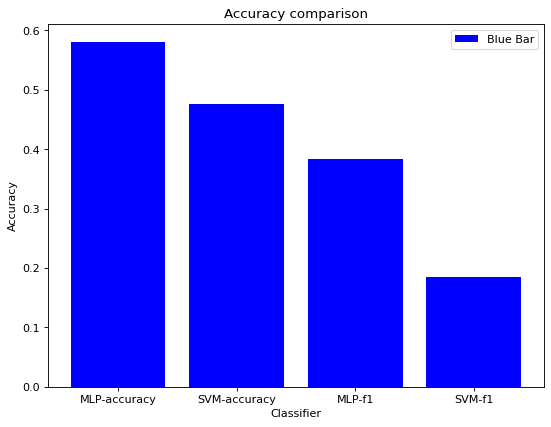

In [ ]:
x1 = ['MLP-accuracy', 'SVM-accuracy', 'MLP-f1', 'SVM-f1']
from matplotlib.pyplot import figure

figure(figsize=(8, 6), dpi=80)
plt.bar(x1, y1, label="Blue Bar", color='b')

plt.plot()

plt.xlabel("Classifier")
plt.ylabel("Accuracy")
plt.title("Accuracy comparison")
plt.legend()
plt.show()
#to-do: change title

Παρατηρούμε ότι ο MLP παρουσιάζει μεγαλύτερο accuracy και f1-score από την LinearSVC. Ωστόσο και ο MLP δεν ξεπερνάει το 70% accuracy. O LinearSVC συγκεκριμένα επίσης παρουσιάζει πολύ κακό f1-score.

#####Βελτιστοποίηση MLP

###### Για την επιλογή του Pipe:
1. Θα βάλουμε Oversampling με τεχνική SMOTE(επειδή βλέπουμε ότι η κλάση Galaxy είναι περίπου 5 φορές μεγαλύτερη από την κλάση Quasar, άρα με RandomOversampling είναι πιθανό να είχαμε μεγάλη επανάληψη της πληροφορίας)
2. Variance Threshold, όπου τις τιμές του threshold θα τις πάρουμε από τις τιμές που βρήκαμε παραπάνω
3. RobustScaler, επειδή βλέπουμε ότι κάποια χαρακτηριστικά έχουν πολύ μεγάλες διακυμάνσεις ($>10^6$), άρα πιθανότατα θα έχουμε και outliers.
4. PCA, για μείωση της διαστατικότητας (αν χρειαστεί εν τέλει)
5. MLP Classifier

In [ ]:
from imblearn.pipeline import Pipeline
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE

# αρχικοποιούμε τον εκτιμητή (ταξινομητής) και τους μετασχηματιστές χωρίς τις υπερ-παραμέτρους που θέλουμε να βελτιστοποιήσουμε
mlp = MLP(solver="adam")
selector = VarianceThreshold()
sampler = SMOTE(n_jobs=-1)
scaler = RobustScaler()
pca = PCA()
pipe = Pipeline(steps=[('sampler', sampler), ('selector', selector), ('scaler', scaler), ('pca', pca), ('MLP', mlp)], memory = 'tmp')


###### Θα χρησιμοποιήσω μόνο τον Adam Solver, διότι στην γενική περίπτωση έχει το καλύτερο performance για μεγάλα datasets (με χιλιάδες δείγματα, όπως το δικό μας dataset). Άρα δεν χρειάζεται να ελέγξω και τα υπόλοιπα Solvers

In [ ]:
from optuna.study import create_study
import optuna

optuna.logging.set_verbosity(optuna.logging.ERROR)


def objective(trial):
    pipe = Pipeline(steps=[('sampler', SMOTE(n_jobs=-1)),
                           ('selector', VarianceThreshold(threshold = trial.suggest_float("Variance_threshold", low=0.5, high=2.0, step=0.2))),
                           ('scaler', RobustScaler()),
                           ('pca', PCA(n_components=trial.suggest_int("PCA_components", 1, 10))),
                           ('MLP', MLP(solver="adam", activation=trial.suggest_categorical("activation", ['logistic', 'relu', 'tanh']), alpha=trial.suggest_loguniform("Alpha", 0.001, 0.1),  hidden_layer_sizes=trial.suggest_categorical("Hidden_layers_size", [(15,), (12, 10), (12, 6)])))],
                    memory = 'tmp')
    scores = cross_val_score(pipe, x_train, y_train, scoring="accuracy", cv=3, n_jobs=-1, error_score=0.0)
    return (sum(scores)/len(scores))


study = optuna.create_study(direction="maximize")
start = time.time()
study.optimize(objective, n_jobs=-1, n_trials=100)
end = time.time()

/opt/conda/lib/python3.7/site-packages/imblearn/pipeline.py:217: UserWarning: Persisting input arguments took 0.61s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name],
/opt/conda/lib/python3.7/site-packages/imblearn/pipeline.py:217: UserWarning: Persisting input arguments took 0.61s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name],
/opt/conda/lib/python3

In [ ]:
print(f'Συνολικά, το hyperparameter-optimization διήρκησε {str(datetime.timedelta(seconds=round(end-start)))}, με το καλύτερο trial να πετυχαίνει accuracy {round(study.best_value, 5)}, με υπερπαραμέτρους: ')
for i in study.best_params:
    print(f"\t{i}: {(study.best_params)[i]}")

Συνολικά, το hyperparameter-optimization διήρκησε 1:15:19, με το καλύτερο trial να πετυχαίνει accuracy 0.96267, με υπερπαραμέτρους: 
	Variance_threshold: 0.5
	PCA_components: 9
	activation: tanh
	Alpha: 0.01582798390741313
	Hidden_layers_size: (12, 10)


In [ ]:
final_estimator = Pipeline(steps=[('sampler', SMOTE(n_jobs=-1)),
                           ('selector', VarianceThreshold(threshold = 0.5)),
                           ('scaler', RobustScaler()),
                           ('pca', PCA(n_components=9)),
                           ('MLP', MLP(solver="adam", activation='tanh', alpha=0.0012943144637461584,  hidden_layer_sizes=(12, 6)))],
                        memory = 'tmp')


start_train_MLP = time.time()
final_estimator.fit(x_train, y_train)
end_train_MLP = time.time()

start_test_MLP = time.time()
prediction_MLP = final_estimator.predict(x_test)
end_test_MLP = time.time()

print(f"Συνολικά, το τελικό μοντέλο χρειάστηκε {round(end_train_MLP-start_train_MLP, 2)} sec για το fitting στο training set, και {round(end_test_MLP-start_test_MLP, 2)} sec για το predict στο test set.")
print(f"\n\n Αναλυτικά, τα αποτελέσματα ήταν:\n")
print(sklearn.metrics.classification_report(y_test, prediction_MLP))

Συνολικά, το τελικό μοντέλο χρειάστηκε 59.99 sec για το fitting στο training set, και 0.05 sec για το predict στο test set.


 Αναλυτικά, τα αποτελέσματα ήταν:

              precision    recall  f1-score   support

      GALAXY       0.98      0.96      0.97     15318
         QSO       0.91      0.94      0.92      3177
        STAR       0.95      0.97      0.96     11505

    accuracy                           0.96     30000
   macro avg       0.95      0.96      0.95     30000
weighted avg       0.96      0.96      0.96     30000



Βλέπουμε ότι τελικά φτάσαμε να έχουμε αρκετά καλή απόδοση (>0.90) σε όλες τις κλάσεις, για όλες τις συχνές μετρικές. Η διαδικασία επιλογής των βημάτων του Pipe εξηγήθηκαν παραπάνω. Όσον αφορά την επιλογή των arguments στην βελτιστοποίηση με την Optuna, μετά από λίγα δοκιμαστικά runs (αφού αξιολογήθηκε ο χρόνος που παίρνει το κάθε trial συγκριτικά με την βελτίωση της μετρικής), βάλαμε το n_trials ίσο με 100. To optimization τελικά κράτησε λίγο παραπάνω από μία ώρα, και έδωσε αρκετά καλά αποτελέσματα.

Όσο για τα υπόλοιπα arguments, στο documentation αναφέρεται ότι ο default sampler δίνει καλά αποτελέσματα στα περισσότερα classification προβλήματα (χωρίς μεγάλο υπολογιστικό φόρτο). Συγκεκριμένα, ο default sampler της Optuna είναι Tree-Structured Parzen Estimator, ο οποίος διαδοχικά κατασκευάζει κάθε φορά ένα σετ υπερπαραμέτρων, με βάση τα αποτελέσματα προηγούμενων trials. Όσο για pruner, δεν χρησιμοποιήθηκε κάποιος, αφού κάθε trial έπαιρνε περίπου 40-55 δευτερόλεπτα για να επιστρέψει το αποτέλεσμα της μετρικής.

#####Βελτιστοποίηση SVM

<h2>Βελτιστοποίηση</h2>
Για τη βελτιστοποίηση του SVC θα χρησιμοποιήσουμε τη βιβλιοθήκη Optuna. Θα δημιουργήσουμε ένα Pipeline με τα components που χρησιμοποιήσαμε και στα Multi-Layer Perceptrons και με το Study.optimize της Optuna θα βρούμε τις καλύτερες παραμέτρους για το Pipeline.

In [ ]:
import numpy as np
import time
from sklearn.svm import LinearSVC
import optuna
from optuna.study import create_study
from imblearn.pipeline import Pipeline
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV, cross_val_score


warnings.filterwarnings("ignore", category=UserWarning)
optuna.logging.set_verbosity(optuna.logging.ERROR)

def objective(trial):
    pipe = Pipeline(steps=[('sampler', SMOTE(n_jobs=-1)),
                           ('selector', VarianceThreshold(threshold = trial.suggest_float("selector__threshold", low=0.5, high=2.0, step=0.2))),
                           ('scaler', RobustScaler()),
                           ('pca', PCA(n_components=trial.suggest_int("pca__n_components", 1, 10))),
                           ('svm', LinearSVC(C = trial.suggest_float("svm__C", low=0.1, high=2.0, step = 0.2)))],
                    memory = 'tmp')
    scores = cross_val_score(pipe, x_train, y_train, scoring="accuracy", cv=5, n_jobs=-1, error_score=0.0)
    return (sum(scores)/len(scores))
                           
study = optuna.create_study(direction="maximize")
start = time.time()
study.optimize(objective, n_jobs=-1, n_trials=80)
end = time.time()

/opt/conda/lib/python3.7/site-packages/imblearn/pipeline.py:226: UserWarning: Persisting input arguments took 0.54s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name],
/opt/conda/lib/python3.7/site-packages/imblearn/pipeline.py:217: UserWarning: Persisting input arguments took 0.74s to run.
If this happens often in your code, it can cause performance problems 
(results will be correct in all cases). 
The reason for this is probably some large input arguments for a wrapped
 function (e.g. large strings).
THIS IS A JOBLIB ISSUE. If you can, kindly provide the joblib's team with an
 example so that they can fix the problem.
  **fit_params_steps[name],
/opt/conda/lib/python3

In [ ]:
print(f'Συνολικά, το hyperparameter-optimization διήρκησε {str(datetime.timedelta(seconds=round(end-start)))}, με το καλύτερο trial να πετυχαίνει accuracy {round(study.best_value, 5)}, με υπερπαραμέτρους: ')
for i in study.best_params:
    print(f"\t{i}: {(study.best_params)[i]}")

Συνολικά, το hyperparameter-optimization διήρκησε 0:57:16, με το καλύτερο trial να πετυχαίνει accuracy 0.82956, με υπερπαραμέτρους: 
	selector__threshold: 1.5
	pca__n_components: 7
	svm__C: 1.7000000000000002


In [ ]:
from sklearn.metrics import classification_report

final_estimator = Pipeline(steps=[('sampler', SMOTE(n_jobs=-1)),
                           ('selector', VarianceThreshold(threshold = 1.5)),
                           ('scaler', RobustScaler()),
                           ('pca', PCA(n_components = 7)),
                           ('svm', LinearSVC(C= 1.7000000000000002))],
                           memory = 'tmp')

start_train_SVC = time.time()
final_estimator.fit(x_train, y_train)
end_train_SVC = time.time()

start_test_SVC = time.time()
prediction_SVC = final_estimator.predict(x_test)
end_test_SVC = time.time()

print(f"Συνολικά, το τελικό μοντέλο χρειάστηκε {round(end_train_SVC-start_train_SVC, 2)} sec για το fitting στο training set, και {round(end_test_SVC-start_test_SVC, 2)} sec για το predict στο test set.")
print(f"\n\n Αναλυτικά, τα αποτελέσματα ήταν:\n")
print(classification_report(y_test, prediction_SVC))

Συνολικά, το τελικό μοντέλο χρειάστηκε 57.72 sec για το fitting στο training set, και 0.0 sec για το predict στο test set.


 Αναλυτικά, τα αποτελέσματα ήταν:

              precision    recall  f1-score   support

      GALAXY       0.91      0.88      0.90     15318
         QSO       0.52      0.85      0.64      3177
        STAR       0.86      0.74      0.79     11505

    accuracy                           0.82     30000
   macro avg       0.76      0.82      0.78     30000
weighted avg       0.85      0.82      0.83     30000



#Σύγκριση αποτελεσμάτων

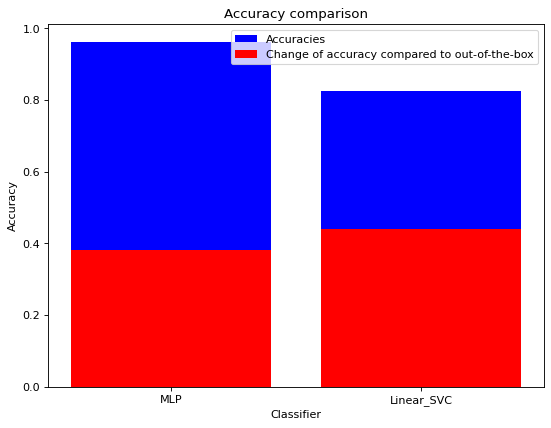

In [ ]:
# Look at index 4 and 6, which demonstrate overlapping cases.
x1 = ['MLP', 'Linear_SVC']
y2 = [accuracy_score(prediction_MLP, y_test), accuracy_score(prediction_SVC, y_test)]

from matplotlib.pyplot import figure

figure(figsize=(8, 6), dpi=80)
plt.bar(x1, y2, label="Accuracies", color='b')
#plt.bar(x1, y2, label = 'Accuracy of out-of-the-box', color='r')
plt.bar(x1, [b-a for a, b in zip([y1[0], y1[2]], y2)], label= 'Change of accuracy compared to out-of-the-box', color='r')
plt.plot()

plt.xlabel("Classifier")
plt.ylabel("Accuracy")
plt.title("Accuracy comparison")
plt.legend()
plt.show()

Παρατηρούμε ότι με τον MLP επιτεύχθηκε εμφανώς καλύτερο accuracy από ότι με τη χρήση Linear_SVC. Η διαφόρα και των δύο ταξινομητών έπειτα από τη βελτιστοποίηση (κόκκινο) είναι μεγάλη και κυμαίνεται στα ίδια επίπεδα

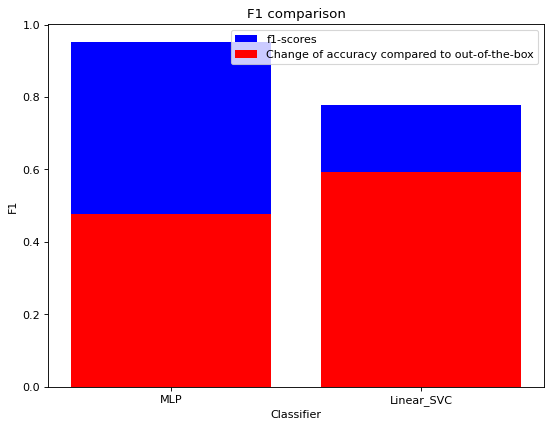

In [ ]:
x1 = ['MLP', 'Linear_SVC']
y2 = [f1_score(prediction_MLP, y_test, average='macro'), f1_score(prediction_SVC, y_test, average = 'macro')]

# Colors: https://matplotlib.org/api/colors_api.html
from matplotlib.pyplot import figure

figure(figsize=(8, 6), dpi=80)
plt.bar(x1, y2, label="f1-scores", color='b')
#plt.bar(x1, y2, label = 'Accuracy of out-of-the-box', color='r')
plt.bar(x1, [b-a for a, b in zip([y1[1], y1[3]], y2)], label= 'Change of accuracy compared to out-of-the-box', color='r')

plt.plot()

plt.xlabel("Classifier")
plt.ylabel("F1")
plt.title("F1 comparison")
plt.legend()
plt.show()

Μεγάλες είναι οι βελτιώσεις και στο f1-score, ειδικά στην περίπτωση του Linear_SVC, ο οποίος είχε παρουσιάσει πολύ μικρό f1-score στην out-of-the-box υλοποίηση του. Παρόλ'αυτά ο MLP είναι καλύτερος από τον Linear_SVC και όσον αφορά το f1-score.

In [ ]:
markdown = """Classifiers  | Accuracy | f1-score | Train Time | Test Time
------------- | ------------- | ------------|---------------|-------------"""
classifierss = ['MLP', 'LinearSVC']
predicts = [prediction_MLP, prediction_SVC]
train_times = [end_train_MLP - start_train_MLP, end_train_SVC - start_train_SVC]
test_times = [end_test_MLP - start_test_MLP, end_test_SVC - start_test_SVC]
y1= []

for i in range(2):
    acc = accuracy_score(predicts[i], y_test)
    y1.append(acc)
    f1 = f1_score(predicts[i], y_test, average = 'macro')
    y1.append(f1)
    markdown += """
     {} | {} | {} | {} | {}""".format(classifierss[i], round(acc,3), round(f1,3), round(train_times[i],4), round(test_times[i],5))
printmd(markdown)

Classifiers  | Accuracy | f1-score | Train Time | Test Time
------------- | ------------- | ------------|---------------|-------------
     MLP | 0.963 | 0.953 | 59.9946 | 0.05051
     LinearSVC | 0.824 | 0.778 | 57.7153 | 0.0049

Στον παραπάνω πίνακα φαίνεται ότι αν και όπως είδαμε στα bar-plots, ο MLP παρουσιάζει καλύτερες επιδόσεις από τον LinearSVC, το predict time του MLP είναι αρκετά μεγαλύτερα. Επίσης σε άλλες εκτελέσεις προέκυπτε για τον MLP και μεγαύτερο fit time.


#Συμπεράσματα

Όπως φάνηκε παραπάνω ο MLP είχε καλύτερες επιδόσεις από τον LinearSVC, τόσο πριν όσο και μετά από την βελτιστοποίηση. Ίσως προέκυπταν καλύτερα αποτελέσματα αν γινόταν χρήση ενός άλλου kernel για το SVM, ωστόσο οι χρόνοι για την εύρεση βέλτιστων παραμέτρων ήταν αποτρεπτικοί. Η επίδοση του, λοιπόν, είναι πιθανό να μην είναι τόσο καλή, επειδή μπορεί τα δεδομένα να μην είναι εντελώς γραμμικά διαχωρίσιμα. Σαν ταξινομήτη θα επιλέγαμε λοιπόν σε αυτό το σύνολο δεδομένων τον Multi Layer Perceptron. Αυτό το συμπέρασμα, είναι σε συμφωνία με την τάση της πτώσης της δημοφιλίας των SVM. 